In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
import PIL
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim



        

In [2]:
data_transforms =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


In [3]:
dataset_path = "../Data/train"
imagenet_data = torchvision.datasets.ImageFolder(dataset_path,transform=data_transforms)

total_data = len(imagenet_data)
train_dataset = int(total_data*0.70)
val_dataset = int(total_data*0.15)
test_dataset = int(total_data-train_dataset-val_dataset)

train_set,val_set,test_set = torch.utils.data.random_split(imagenet_data,[train_dataset,val_dataset,test_dataset])

train_dataset = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_dataset= torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_dataset = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

train_image,train_label =next(iter(train_dataset))
total_data = len(train_dataset)
print(total_data)
print(len(imagenet_data))
print(train_image.shape)

175
8000
torch.Size([32, 3, 224, 224])


<class 'torch.Tensor'>
torch.Size([3, 224, 224])


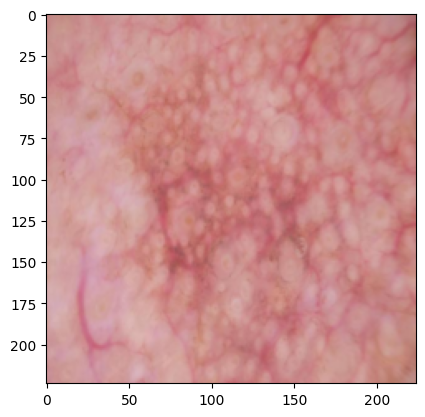

In [4]:
image , label =imagenet_data[0]
print(type(image))
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [5]:
class SkinCancerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.katman =nn.Sequential(
        nn.Flatten(),
        nn.Linear(150528,224),
        nn.ReLU(),
        nn.Linear(224,7)
    )
    def forward(self, x):
       x = self.katman(x)
       return x
    



        

In [6]:
model = SkinCancerModel()
predictions = model(train_image)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
print(predictions.shape)

torch.Size([32, 7])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
loss = criterion (predictions,train_label)
print("Loss before training:",loss.item())

optimizer.zero_grad()
loss.backward()
optimizer.step()

new_predictions = model(train_image)
new_loss = criterion(new_predictions,train_label)


print("Loss after training:", new_loss.item())


Loss before training: 2.0031237602233887
Eğitimden sonraki hata: 1.3708500862121582


In [11]:
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
model =model.to(device)
for epoch in range(5):
    total_loss = 0
    for image ,label in train_dataset:
        image = image.to(device)
        label = label.to(device)
        
        predict = model(image)
        loss = criterion(predict,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} completed. Mean Loss: {total_loss/len(train_dataset)}")

Epoch 1 completed. Mean Loss: 0.973583550112588
Epoch 2 completed. Mean Loss: 0.9559030204159873
Epoch 3 completed. Mean Loss: 0.9430375831467764
Epoch 4 completed. Mean Loss: 0.931400158064706
Epoch 5 completed. Mean Loss: 0.9148180551188333


In [13]:
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
model =model.to(device)
for epoch in range(5):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_dataset:
        image , label = image.to(device),label.to(device)
        predict = model(image)
        loss = criterion(predict,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    mean_loss = total_loss / len(train_dataset)

    success_rate = (total_accuary / len(train_dataset.dataset)) * 100

    print(f"Epoch {epoch+1} completed. Mean Loss: {total_loss/len(train_dataset)}")


Epoch 1 completed. Mean Loss: 0.9236129006317684
Epoch 2 completed. Mean Loss: 0.9068000762803214
Epoch 3 completed. Mean Loss: 0.8999941461426871
Epoch 4 completed. Mean Loss: 0.8964202264377049
Epoch 5 completed. Mean Loss: 0.8920132025650569


In [14]:
model.eval()
model =model.to(device)
with torch.no_grad():

    criterion= nn.CrossEntropyLoss()

    total_loss = 0
    total_accuary = 0
    for image ,label in test_dataset:
        image , label = image.to(device),label.to(device)
        predict = model(image)
        hata = criterion(predict,label)

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(test_dataset)

    yuzdelik_basari = (total_accuary / len(test_dataset.dataset)) * 100

    print(f"🎉 TEST RESULT | Mean Loss: {ortalama_hata:.4f} | Success Rate: %{success_rate:.2f}")

    


🎉 TEST RESULT | Mean Loss: 0.8959 | Success Rate: %68.88


In [15]:
import os
torch.save(model.state_dict(), "cepteki_dermatolog_linear_v1.pth")
print("Is the model file available?:", os.path.exists("cepteki_dermatolog_linear_v1.pth"))

Is the model file available?: True


In [16]:

test_model = SkinCancerModel() 
test_model.load_state_dict(torch.load("cepteki_dermatolog_linear_v1.pth"))
test_model.eval()

print("✅ The model was successfully saved and restored!")

C:\Users\akarf\AppData\Local\Temp\ipykernel_20160\4096245687.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("cepteki_dermatolog_li

✅ The model was successfully saved and restored!


In [17]:
num_classes = 7
class SkinCancerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50176,128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        
        x = self.flatten(x)

       
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
new_model = SkinCancerModelV2()



In [18]:
import random as rand
fake_picture = torch.rand(1, 3, 224, 224)
result= new_model(fake_picture)
print (result.shape)

torch.Size([1, 7])


In [19]:
model_v2 = SkinCancerModelV2()

In [20]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA installed?:", torch.cuda.is_available())
print("How many GPUs are there?:", torch.cuda.device_count())

PyTorch version: 2.5.1+cu121
Is CUDA installed?: True
How many GPUs are there?: 1


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(),lr=0.0001)
model_v2.to(device)
model_v2.train()
for epoch in range(15):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_dataset:
        image = image.to(device)
        label= label.to(device)
        predict = model_v2(image)
        hata = criterion(predict,label)

        optimizer.zero_grad()
        hata.backward()
        optimizer.step()

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(train_dataset)

    yuzdelik_basari = (total_accuary / len(train_dataset.dataset)) * 100

    print(f"Epoch {epoch+1} tamamlandı. Ortalama Hata: {total_loss/len(train_dataset)},Yüzdelik Başari: {yuzdelik_basari}")


Using device: cuda
Epoch 1 tamamlandı. Ortalama Hata: 1.1586336435590472,Yüzdelik Başari: 66.67857142857143
Epoch 2 tamamlandı. Ortalama Hata: 0.9930480677740915,Yüzdelik Başari: 67.08928571428572
Epoch 3 tamamlandı. Ortalama Hata: 0.9344321380342756,Yüzdelik Başari: 67.53571428571429
Epoch 4 tamamlandı. Ortalama Hata: 0.8906368090425218,Yüzdelik Başari: 67.96428571428571
Epoch 5 tamamlandı. Ortalama Hata: 0.8743721306324005,Yüzdelik Başari: 68.55357142857143
Epoch 6 tamamlandı. Ortalama Hata: 0.8555364176205227,Yüzdelik Başari: 68.32142857142857
Epoch 7 tamamlandı. Ortalama Hata: 0.8420091702256884,Yüzdelik Başari: 69.42857142857143
Epoch 8 tamamlandı. Ortalama Hata: 0.833870940549033,Yüzdelik Başari: 69.41071428571428
Epoch 9 tamamlandı. Ortalama Hata: 0.8202787610462734,Yüzdelik Başari: 69.73214285714285
Epoch 10 tamamlandı. Ortalama Hata: 0.8152700000149863,Yüzdelik Başari: 70.14285714285714
Epoch 11 tamamlandı. Ortalama Hata: 0.7912786080156053,Yüzdelik Başari: 70.92857142857143
E

In [22]:
torch.save(model_v2.state_dict(), 'dermatologist_v2_weights.pth')

🎉 TEST RESULT | Loss Mean: 0.7680 | Succcess Rate: %69.83


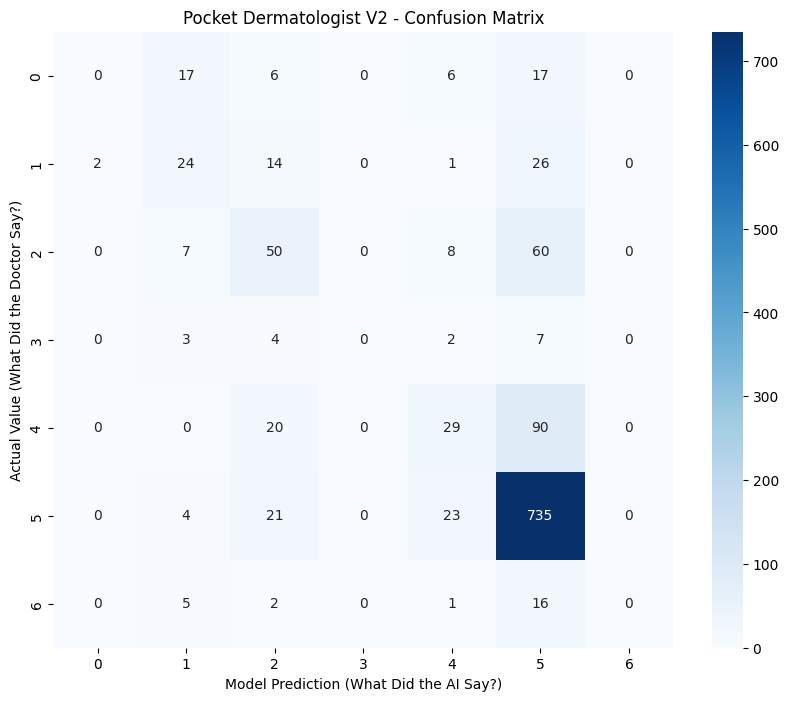

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_v2.eval()
model_v2 =model_v2.to(device)
criterion= nn.CrossEntropyLoss()
real_labels = []
model_predictions = []

with torch.no_grad():

    total_loss = 0
    total_accuary = 0

    for image ,label in val_dataset:
        image , label = image.to(device),label.to(device)
        predict = model_v2(image)
        loss= criterion(predict,label)

        total_loss += loss.item()

        predictions = torch.argmax(predict,dim=1)

        package_truth  = (predictions == label).sum().item()
        total_accuary += package_truth 

        model_predictions.extend(predictions.cpu().numpy())
        real_labels.extend(label.cpu().numpy())

    mean_loss = total_loss / len(val_dataset)

    success_rate = (total_accuary / len(val_dataset.dataset)) * 100

    print(f"🎉 TEST RESULT | Loss Mean: {ortalama_hata:.4f} | Succcess Rate: %{success_rate:.2f}")




cm = confusion_matrix(real_labels, model_predictions)

# 2. Şık Bir Tablo (Heatmap) Olarak Çizdir
plt.figure(figsize=(10, 8)) # Tablonun boyutu
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # annot=True sayıları gösterir, cmap renk tonudur
plt.xlabel('Model Prediction (What Did the AI Say?)')
plt.ylabel('Actual Value (What Did the Doctor Say?)')
plt.title('Pocket Dermatologist V2 - Confusion Matrix')
plt.show()
    
